# Chest X-Ray Images (Pneumonia)

Data found here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/

There are 3 different sets: test, train, validation. Load in all of them. Start with the imports.

In [507]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import datasets, layers, models, callbacks, regularizers
from sklearn.metrics import confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from keras.optimizers import SGD, Adam
from keras.metrics import Recall, Precision

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# create directory paths to where the data is saved for each train, test, val
train_path = 'Data/chest_xray/train'
test_path = 'Data/chest_xray/test'
val_path = 'Data/chest_xray/val'

Before rescaling it, let's get an idea of the size of the original images. Let's load it in with no parameters set except for batch_size.

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=5216)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=624)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=16)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


I want to know if each image in the images set are the same size. Let's create a list, loop through each image set, then take the set of it to get the unique entries. 

In [4]:
# loop through each images in the array and add the size to a list

train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [5]:
# how many unique sizes are in each list? should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"original train size: {unique_train_sizes}")
print(f"original test size: {unique_test_sizes}")
print(f"original val size: {unique_val_sizes}")

original train size: [(256, 256)]
original test size: [(256, 256)]
original val size: [(256, 256)]


So the original scale of all of the pictures was 256 x 256. 

Let's next visualize the distribution of images - how many are normal, how many are pneumonia.

In [214]:
normal_train_path = 'Data/chest_xray/train/normal'
pneumonia_train_path = 'Data/chest_xray/train/pneumonia'

In [215]:
normal_count = len(os.listdir(normal_train_path))
pneumonia_count = len(os.listdir(pneumonia_train_path))
print(f'normal: {normal_count}')
print(f'pneumonia: {pneumonia_count}')

normal: 1342
pneumonia: 3876


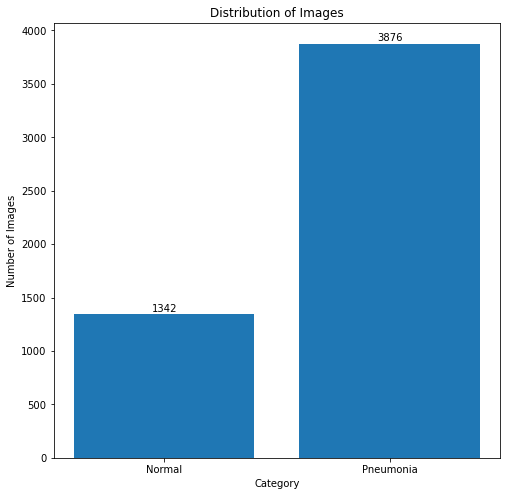

In [223]:
categories = ['Normal', 'Pneumonia']
counts = [normal_count, pneumonia_count]

fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

So we have 1342 normal images and 3876 pneumonia images. 

Now that we have an idea of what we're working with, let's reload, scale to 64x64 and normalize. 

In [6]:
# notes from david
# validation - use at very very end to test it
# train on test, test against test, validation = holdout set

# to do
# check size of original images
# change target, use sigmoid
# change labels from [0,1] to either 0 or 1 since this is binary not multi class

In [7]:
# look at the max of each image for normalization
print(f"train max: {original_train_images[0].max()}")
print(f"test max: {original_test_images[0].max()}")
print(f"val max: {original_val_images[0].max()}")

train max: 255.0
test max: 255.0
val max: 255.0


In [94]:
# load in data
# normalize with rescale = 1.0/255
# resize each image to be 64x64

train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        train_path, 
        target_size=(64, 64), batch_size=5216) # look up how it impacts results on doc string

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path, 
        target_size=(64, 64), batch_size=624)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Check the size and a few images to make sure they loaded correctly. 

In [95]:
array_to_img(train_images[791]).size

(64, 64)

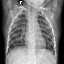

In [96]:
# check out some images to make sure they loaded properly
array_to_img(train_images[791])

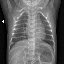

In [97]:
array_to_img(train_images[0])

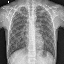

In [98]:
array_to_img(test_images[0])

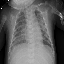

In [99]:
array_to_img(val_images[0])

Let's check out the shapes and make sure they all line up as expected. 

In [224]:
# look at the shapes
print(f"train images: {train_images.shape}")
print(f"train labels: {train_labels.shape}")
print(f"test images: {test_images.shape}")
print(f"test labels: {test_labels.shape}")
print(f"val images: {val_images.shape}")
print(f"val labels: {val_labels.shape}")

train images: (5216, 64, 64, 3)
train labels: (5216, 2)
test images: (100, 64, 64, 3)
test labels: (100, 2)
val images: (16, 64, 64, 3)
val labels: (16, 2)


The labels each have shape (x, 2) implying it's multiclass. This is a binary classification (it's either pneumonia or normal) so we need to change the shape to be (x, 1). So change output from [0,1] or [1,0] to be either 0 or 1.

In [101]:
# look at what each data set is classifying as normal vs pneumonia
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [102]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [103]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Change the labels from multi to binary

In [18]:
# there are 3875 pneumonia images and 1341 normal images
# using T[0] targets the minority class (normal) as the positive class (class 1)
# The models primary task becomes predicting the normal class, which is the minority class
# prioritize recall - want to minimize number of missed pneumonia 

In [104]:
# train_labels.T[0] selects the first row of the transposed matrix. Should correspond to normal.
# train_labels.T[1] selects the second row of the transposed matrix. should correspond to pneumonia.
# using train_labels.T[0] swaps the results. 
# so use train_labels.T[1]

# it will always try to predict the "1" class - are we trying to predict pneumnoia or normal

train_labels_final = train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"train labels updated shape: {train_labels_final.shape}")
print(f"test labels updated shape: {test_labels_final.shape}")
print(f"val labels updated shape: {val_labels_final.shape}")

train labels updated shape: (5216,)
test labels updated shape: (624,)
val labels updated shape: (16,)


In [105]:
print(f"original train labels shape: {train_labels.shape}")
print(f"updated train labels shape: {train_labels_final.shape}")

original train labels shape: (5216, 2)
updated train labels shape: (5216,)


Check it out: visually inspect to see if these labels make sense.

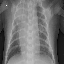

In [106]:
array_to_img(train_images[241])

In [107]:
# class 0: this is "normal", looks like pneumonia
train_labels_final[241]

0.0

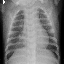

In [108]:
array_to_img(train_images[461])

In [109]:
# class 0: this is "normal", looks like pneumonia
train_labels_final[461]

0.0

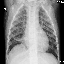

In [110]:
array_to_img(train_images[11])

In [111]:
# class 0: this is "normal", looks like pneumonia
train_labels_final[11]

0.0

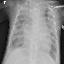

In [112]:
array_to_img(train_images[7])

In [113]:
# class 0: this is "normal", looks like pneumonia
train_labels_final[7]

0.0

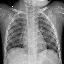

In [114]:
array_to_img(train_images[89])

In [115]:
# class 1: this is "pneumonia", looks normal
train_labels_final[89]

1.0

In [31]:
# so switching them means that normal would become class 1 and pneumonia would be class 0. 
# labels might be switched - look into this

In [32]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Base model: create a basic sequential model with 1 input layer, flatten it, and have a dense output layer. Using sigmoid as the output activation since this is a binary classification. 

In [484]:
# base: 75% class 0 and 25% class 1
pd.Series(train_labels_final).value_counts(normalize=True)

0.0    0.742906
1.0    0.257094
dtype: float64

First base model:

In [33]:
baseline_model = models.Sequential()
baseline_model.add(layers.Conv2D(filters=32,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(64, 64, 3)))

baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
# look at the smmary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 123009    
Total params: 123,905
Trainable params: 123,905
Non-trainable params: 0
_________________________________________________________________


In [35]:
# compile it
# using adam to start
# binary_crossentropy because this is a binary classification
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [36]:
# fit on the model
baseline_results = baseline_model.fit(train_images, 
                                      train_labels_final, 
                                      epochs=25, 
                                      batch_size=75)

Epoch 1/25
70/70 [==============================] - 4s 59ms/step - loss: 0.4789 - accuracy: 0.8361
Epoch 2/25
70/70 [==============================] - 4s 60ms/step - loss: 0.1396 - accuracy: 0.9509
Epoch 3/25
70/70 [==============================] - 4s 57ms/step - loss: 0.1013 - accuracy: 0.9651
Epoch 4/25
70/70 [==============================] - 4s 59ms/step - loss: 0.0870 - accuracy: 0.9693
Epoch 5/25
70/70 [==============================] - 5s 64ms/step - loss: 0.0703 - accuracy: 0.9768
Epoch 6/25
70/70 [==============================] - 5s 68ms/step - loss: 0.0642 - accuracy: 0.9783
Epoch 7/25
70/70 [==============================] - 5s 74ms/step - loss: 0.0457 - accuracy: 0.9870
Epoch 8/25
70/70 [==============================] - 5s 77ms/step - loss: 0.0391 - accuracy: 0.9870
Epoch 9/25
70/70 [==============================] - 5s 74ms/step - loss: 0.0318 - accuracy: 0.9919
Epoch 10/25
70/70 [==============================] - 5s 66ms/step - loss: 0.0312 - accuracy: 0.9918
Epoch 11/

In [37]:
# train scores
train_loss, train_acc = baseline_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 2s 13ms/step - loss: 0.0022 - accuracy: 1.0000


In [38]:
# test scores
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 10ms/step - loss: 1.7055 - accuracy: 0.7308


Train accuracy is 1 and test is 74 - this model is super overfit. Trying again by adding some hidden layers. 

In [39]:
first_model = models.Sequential()
first_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

first_model.add(layers.MaxPooling2D(pool_size=(2, 2))) # add hidden layer
first_model.add(layers.Conv2D(64, (3, 3), activation='relu')) # add hidden layer

first_model.add(layers.Flatten())
first_model.add(layers.Dense(1, activation='sigmoid'))

In [40]:
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 53825     
Total params: 73,217
Trainable params: 73,217
Non-trainable params: 0
_________________________________________________________________


In [41]:
first_model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [42]:
first_results = first_model.fit(train_images, train_labels_final, 
          epochs=25, 
          batch_size=75)

Epoch 1/25
70/70 [==============================] - 12s 165ms/step - loss: 0.3243 - accuracy: 0.8700
Epoch 2/25
70/70 [==============================] - 16s 223ms/step - loss: 0.1286 - accuracy: 0.9515
Epoch 3/25
70/70 [==============================] - 19s 273ms/step - loss: 0.1014 - accuracy: 0.9597
Epoch 4/25
70/70 [==============================] - 18s 260ms/step - loss: 0.0819 - accuracy: 0.9701
Epoch 5/25
70/70 [==============================] - 14s 200ms/step - loss: 0.0687 - accuracy: 0.9741s - loss: 0.0686 - accura
Epoch 6/25
70/70 [==============================] - 16s 230ms/step - loss: 0.0586 - accuracy: 0.9799
Epoch 7/25
70/70 [==============================] - 19s 269ms/step - loss: 0.0665 - accuracy: 0.9766
Epoch 8/25
70/70 [==============================] - 18s 254ms/step - loss: 0.0475 - accuracy: 0.9824
Epoch 9/25
70/70 [==============================] - 18s 252ms/step - loss: 0.0397 - accuracy: 0.9841
Epoch 10/25
70/70 [==============================] - 21s 297ms/ste

In [43]:
train_loss, train_acc = first_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 5s 32ms/step - loss: 9.5492e-04 - accuracy: 1.0000


In [44]:
test_loss, test_acc = first_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 24ms/step - loss: 2.3061 - accuracy: 0.7548


Slightly better test score at 75%, but as train score is still 1, this is still super overfit. Visualizing the accuracy below. 

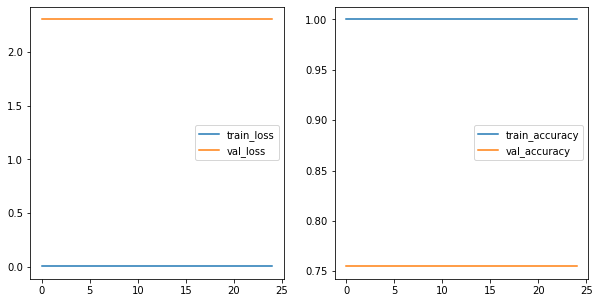

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=first_results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=first_results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=first_results.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=first_results.epoch, y=test_acc, ax=ax2, label='val_accuracy');

Making another model by adding more hidden layers:

In [46]:
second_model = models.Sequential()
second_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

second_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
second_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
second_model.add(layers.MaxPooling2D((2, 2)))
second_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
second_model.add(layers.Flatten())
second_model.add(layers.Dense(1, activation='sigmoid'))

In [47]:
second_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [48]:
second_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [49]:
second_results = second_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 21s 295ms/step - loss: 0.4047 - accuracy: 0.8248
Epoch 2/25
70/70 [==============================] - 19s 274ms/step - loss: 0.1496 - accuracy: 0.9421
Epoch 3/25
70/70 [==============================] - 21s 294ms/step - loss: 0.1135 - accuracy: 0.9572
Epoch 4/25
70/70 [==============================] - 18s 256ms/step - loss: 0.0994 - accuracy: 0.9599
Epoch 5/25
70/70 [==============================] - 18s 254ms/step - loss: 0.0798 - accuracy: 0.9689
Epoch 6/25
70/70 [==============================] - 18s 255ms/step - loss: 0.0762 - accuracy: 0.9734
Epoch 7/25
70/70 [==============================] - 18s 256ms/step - loss: 0.0628 - accuracy: 0.9772
Epoch 8/25
70/70 [==============================] - 18s 253ms/step - loss: 0.0589 - accuracy: 0.9757
Epoch 9/25
70/70 [==============================] - 18s 253ms/step - loss: 0.0556 - accuracy: 0.9795
Epoch 10/25
70/70 [==============================] - 18s 252ms/step - loss: 0.0485 - accura

In [50]:
train_loss, train_acc = second_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 9s 56ms/step - loss: 0.0062 - accuracy: 0.9992


In [51]:
test_loss, test_acc = second_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 1s 29ms/step - loss: 1.3601 - accuracy: 0.7933


About the same, train score came down minutely, test score increased to 79. Still overfit, try adding regularization:

In [52]:
# starting with adding just L2 regularizer, strength 0.01
third_model = models.Sequential()
third_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3),
                        kernel_regularizer=regularizers.l2(0.01)))

third_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
third_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
third_model.add(layers.MaxPooling2D((2, 2)))
third_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
third_model.add(layers.Flatten())
third_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [53]:
third_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [54]:
third_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [55]:
third_results = third_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 19s 276ms/step - loss: 0.9157 - accuracy: 0.8100
Epoch 2/25
70/70 [==============================] - 20s 282ms/step - loss: 0.3496 - accuracy: 0.9254
Epoch 3/25
70/70 [==============================] - 21s 301ms/step - loss: 0.2755 - accuracy: 0.9400
Epoch 4/25
70/70 [==============================] - 22s 310ms/step - loss: 0.2457 - accuracy: 0.9457
Epoch 5/25
70/70 [==============================] - 26s 376ms/step - loss: 0.2223 - accuracy: 0.9532
Epoch 6/25
70/70 [==============================] - 26s 369ms/step - loss: 0.2197 - accuracy: 0.9496
Epoch 7/25
70/70 [==============================] - 20s 290ms/step - loss: 0.1926 - accuracy: 0.9551
Epoch 8/25
70/70 [==============================] - 19s 269ms/step - loss: 0.1880 - accuracy: 0.9565
Epoch 9/25
70/70 [==============================] - 21s 294ms/step - loss: 0.1801 - accuracy: 0.9592
Epoch 10/25
70/70 [==============================] - 9s 129ms/step - loss: 0.2155 - accurac

In [56]:
train_loss, train_acc = third_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 7s 41ms/step - loss: 0.1567 - accuracy: 0.9684


In [57]:
test_loss, test_acc = third_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 22ms/step - loss: 0.7901 - accuracy: 0.7516


Train accuracy at 96 and test accuracy at 75. Trying adding dropout regularization. 

In [58]:
fourth_model = models.Sequential()
fourth_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3),
                        kernel_regularizer=regularizers.l2(0.01)))

fourth_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
fourth_model.add(layers.Dropout(0.8))
fourth_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
fourth_model.add(layers.Dropout(0.6))
fourth_model.add(layers.MaxPooling2D((2, 2)))
fourth_model.add(layers.Dropout(0.4))
fourth_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
fourth_model.add(layers.Dropout(0.2))
fourth_model.add(layers.Flatten())
fourth_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [59]:
fourth_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)       

In [60]:
fourth_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [61]:
fourth_results = fourth_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 28s 406ms/step - loss: 1.3464 - accuracy: 0.7343
Epoch 2/25
70/70 [==============================] - 33s 465ms/step - loss: 0.6991 - accuracy: 0.8397
Epoch 3/25
70/70 [==============================] - 34s 484ms/step - loss: 0.4699 - accuracy: 0.8982
Epoch 4/25
70/70 [==============================] - 28s 395ms/step - loss: 0.3795 - accuracy: 0.9172
Epoch 5/25
70/70 [==============================] - 27s 385ms/step - loss: 0.3458 - accuracy: 0.9179
Epoch 6/25
70/70 [==============================] - 28s 404ms/step - loss: 0.3034 - accuracy: 0.9237
Epoch 7/25
70/70 [==============================] - 29s 419ms/step - loss: 0.2889 - accuracy: 0.9262
Epoch 8/25
70/70 [==============================] - 29s 415ms/step - loss: 0.2759 - accuracy: 0.9289
Epoch 9/25
70/70 [==============================] - 30s 431ms/step - loss: 0.2651 - accuracy: 0.9335
Epoch 10/25
70/70 [==============================] - 32s 459ms/step - loss: 0.2625 - accura

In [62]:
train_loss, train_acc = fourth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 3s 18ms/step - loss: 0.3522 - accuracy: 0.8451


In [63]:
test_loss, test_acc = fourth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 17ms/step - loss: 0.8807 - accuracy: 0.6410


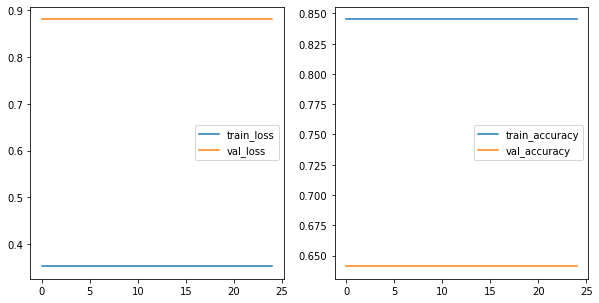

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=fourth_results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=fourth_results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=fourth_results.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=fourth_results.epoch, y=test_acc, ax=ax2, label='val_accuracy');

Still overfit. Train accuracy is a little better at 85, but test score is worse at 64. Let's try changing the activation functions to tanh.

In [66]:
fifth_model = models.Sequential()
fifth_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='tanh',
                        input_shape=(64, 64, 3),
                        kernel_regularizer=regularizers.l2(0.01)))

fifth_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
fifth_model.add(layers.Dropout(0.8))
fifth_model.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
fifth_model.add(layers.Dropout(0.2))
fifth_model.add(layers.Flatten())
fifth_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [67]:
fifth_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [68]:
fifth_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [69]:
fifth_results = fifth_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 11s 156ms/step - loss: 0.9053 - accuracy: 0.8044
Epoch 2/25
70/70 [==============================] - 12s 165ms/step - loss: 0.5656 - accuracy: 0.9185
Epoch 3/25
70/70 [==============================] - 11s 163ms/step - loss: 0.4409 - accuracy: 0.9377
Epoch 4/25
70/70 [==============================] - 12s 165ms/step - loss: 0.3640 - accuracy: 0.9456
Epoch 5/25
70/70 [==============================] - 11s 161ms/step - loss: 0.3227 - accuracy: 0.9479
Epoch 6/25
70/70 [==============================] - 12s 168ms/step - loss: 0.2851 - accuracy: 0.9540
Epoch 7/25
70/70 [==============================] - 11s 154ms/step - loss: 0.2657 - accuracy: 0.9511
Epoch 8/25
70/70 [==============================] - 11s 157ms/step - loss: 0.2647 - accuracy: 0.9448
Epoch 9/25
70/70 [==============================] - 12s 175ms/step - loss: 0.2479 - accuracy: 0.9488
Epoch 10/25
70/70 [==============================] - 17s 236ms/step - loss: 0.2326 - accura

In [70]:
train_loss, train_acc = fifth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 3s 16ms/step - loss: 0.1970 - accuracy: 0.9561


In [71]:
test_loss, test_acc = fifth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 14ms/step - loss: 0.9017 - accuracy: 0.7147


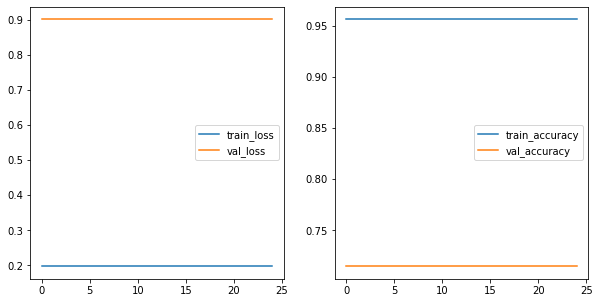

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=fifth_results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=fifth_results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=fifth_results.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=fifth_results.epoch, y=test_acc, ax=ax2, label='val_accuracy');

Didn't really change much. Let's try changing the optimizer from Adam to SGD. 

In [73]:
fifth_model.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [75]:
fifth_results = fifth_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 18s 257ms/step - loss: 0.1943 - accuracy: 0.9580
Epoch 2/25
70/70 [==============================] - 15s 210ms/step - loss: 0.1911 - accuracy: 0.9638
Epoch 3/25
70/70 [==============================] - 15s 215ms/step - loss: 0.1866 - accuracy: 0.9615
Epoch 4/25
70/70 [==============================] - 15s 207ms/step - loss: 0.1863 - accuracy: 0.9617
Epoch 5/25
70/70 [==============================] - 14s 202ms/step - loss: 0.1853 - accuracy: 0.9609
Epoch 6/25
70/70 [==============================] - 17s 241ms/step - loss: 0.1839 - accuracy: 0.9601
Epoch 7/25
70/70 [==============================] - 14s 202ms/step - loss: 0.1862 - accuracy: 0.9617
Epoch 8/25
70/70 [==============================] - 14s 203ms/step - loss: 0.1841 - accuracy: 0.9609
Epoch 9/25
70/70 [==============================] - 14s 201ms/step - loss: 0.1811 - accuracy: 0.9622
Epoch 10/25
70/70 [==============================] - 14s 200ms/step - loss: 0.1787 - accura

In [76]:
train_loss, train_acc = fifth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 4s 27ms/step - loss: 0.1603 - accuracy: 0.9691


In [77]:
test_loss, test_acc = fifth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 18ms/step - loss: 0.7762 - accuracy: 0.7388


Not any better, trying nadam next. 

In [78]:
fifth_model.compile(optimizer='nadam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [79]:
fifth_results = fifth_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 20s 282ms/step - loss: 0.2073 - accuracy: 0.9475
Epoch 2/25
70/70 [==============================] - 24s 344ms/step - loss: 0.1966 - accuracy: 0.9528
Epoch 3/25
70/70 [==============================] - 25s 355ms/step - loss: 0.2222 - accuracy: 0.9450
Epoch 4/25
70/70 [==============================] - 21s 296ms/step - loss: 0.1928 - accuracy: 0.9523
Epoch 5/25
70/70 [==============================] - 20s 290ms/step - loss: 0.1861 - accuracy: 0.9574
Epoch 6/25
70/70 [==============================] - 20s 290ms/step - loss: 0.1915 - accuracy: 0.9548
Epoch 7/25
70/70 [==============================] - 20s 293ms/step - loss: 0.1886 - accuracy: 0.9565
Epoch 8/25
70/70 [==============================] - 21s 303ms/step - loss: 0.1884 - accuracy: 0.9546
Epoch 9/25
70/70 [==============================] - 20s 291ms/step - loss: 0.1865 - accuracy: 0.9574
Epoch 10/25
70/70 [==============================] - 21s 293ms/step - loss: 0.1862 - accura

In [80]:
train_loss, train_acc = fifth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 5s 33ms/step - loss: 0.1768 - accuracy: 0.9628


In [81]:
test_loss, test_acc = fifth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 22ms/step - loss: 0.9329 - accuracy: 0.7099


Train score 96 test 71 - not any better than earlier models, a little bit worse actually. Sticking with adam optimizer. 

Let's try adding in the learning rate. Starting with strength 0.1

In [82]:
fifth_model.compile(optimizer=Adam(lr=0.1), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [83]:
fifth_results = fifth_model.fit(train_images, train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
70/70 [==============================] - 20s 289ms/step - loss: 413.9123 - accuracy: 0.6296
Epoch 2/25
70/70 [==============================] - 22s 312ms/step - loss: 465.2189 - accuracy: 0.6100
Epoch 3/25
70/70 [==============================] - 23s 322ms/step - loss: 258.7058 - accuracy: 0.6202
Epoch 4/25
70/70 [==============================] - 22s 315ms/step - loss: 310.9782 - accuracy: 0.6143
Epoch 5/25
70/70 [==============================] - 22s 315ms/step - loss: 395.4731 - accuracy: 0.6166
Epoch 6/25
70/70 [==============================] - 20s 281ms/step - loss: 442.4156 - accuracy: 0.6235
Epoch 7/25
70/70 [==============================] - 21s 304ms/step - loss: 275.4847 - accuracy: 0.6240
Epoch 8/25
70/70 [==============================] - 23s 329ms/step - loss: 160.5272 - accuracy: 0.6411
Epoch 9/25
70/70 [==============================] - 24s 340ms/step - loss: 134.8033 - accuracy: 0.6931
Epoch 10/25
70/70 [==============================] - 22s 311ms/step - los

In [84]:
train_loss, train_acc = fifth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 7s 43ms/step - loss: 98.6009 - accuracy: 0.7655


In [85]:
test_loss, test_acc = fifth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 1s 26ms/step - loss: 91.9809 - accuracy: 0.7853


Train score at 77 and test score at 78 - this is performing okay, but for once it's not overfit!!

Let's add more layers.

In [86]:
sixth_model = models.Sequential()
sixth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))
sixth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))
sixth_model.add(layers.Dropout(.3))
sixth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
sixth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
sixth_model.add(layers.Dropout(.3))
sixth_model.add(layers.Flatten())
sixth_model.add(layers.Dense(1, activation='sigmoid'))

In [87]:
sixth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
sixth_results = sixth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 27s 329ms/step - loss: 0.4926 - accuracy: 0.7995
Epoch 2/20
82/82 [==============================] - 33s 397ms/step - loss: 0.1838 - accuracy: 0.9291
Epoch 3/20
82/82 [==============================] - 26s 315ms/step - loss: 0.1525 - accuracy: 0.9438
Epoch 4/20
82/82 [==============================] - 28s 344ms/step - loss: 0.1317 - accuracy: 0.9486
Epoch 5/20
82/82 [==============================] - 27s 335ms/step - loss: 0.1200 - accuracy: 0.9549
Epoch 6/20
82/82 [==============================] - 36s 445ms/step - loss: 0.1279 - accuracy: 0.9515
Epoch 7/20
82/82 [==============================] - 27s 326ms/step - loss: 0.1104 - accuracy: 0.9574
Epoch 8/20
82/82 [==============================] - 33s 397ms/step - loss: 0.1145 - accuracy: 0.9538
Epoch 9/20
82/82 [==============================] - 28s 343ms/step - loss: 0.1056 - accuracy: 0.9613
Epoch 10/20
82/82 [==============================] - 33s 398ms/step - loss: 0.1175 - accura

In [90]:
train_loss, train_acc = sixth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 2s 14ms/step - loss: 0.2052 - accuracy: 0.9218


In [91]:
test_loss, test_acc = sixth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 13ms/step - loss: 0.7737 - accuracy: 0.7372


That didn't help. Let's try augmenting the data.

### Trying Data Augmentation

Load in the data using ImageDataGenerator and flip it horizontally (vertically would flip it upside down). Just using it on the training data so we can generate more images to train our models on. Also changed the batch sizes. 

In [116]:
# augment the train set to generate more images
aug_train_generator = ImageDataGenerator(rescale=1.0/255,
                                         horizontal_flip=True,
                                         height_shift_range=0.2,
                                         width_shift_range=0.2,
                                         rotation_range=45,
                                         brightness_range=[0.2,1],
                                         zoom_range=0.2
                                         ).flow_from_directory(train_path, target_size=(64, 64), batch_size=700) 

# keeping these the same as originally put in. Changed the batch sizes. 
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path, 
        target_size=(64, 64), batch_size=100)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
aug_train_images, aug_train_labels = next(aug_train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Check out a few images.

In [117]:
array_to_img(aug_train_images[0]).size

(64, 64)

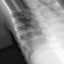

In [118]:
array_to_img(aug_train_images[0])

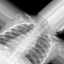

In [119]:
array_to_img(aug_train_images[9])

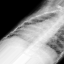

In [120]:
array_to_img(aug_train_images[108])

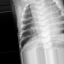

In [121]:
array_to_img(aug_train_images[631])

Same as before, change the labels from [1,0] and [0,1] to either 0 or 1. 

In [123]:
aug_train_labels_final = aug_train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"aug train labels updated shape: {aug_train_labels_final.shape}")
print(f"test labels updated shape: {test_labels_final.shape}")
print(f"val labels updated shape: {val_labels_final.shape}")

aug train labels updated shape: (700,)
test labels updated shape: (100,)
val labels updated shape: (16,)


In [124]:
print(f"original train labels shape: {aug_train_labels.shape}")
print(f"updated train labels shape: {aug_train_labels_final.shape}")

original train labels shape: (700, 2)
updated train labels shape: (700,)


Check it out.

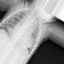

In [125]:
array_to_img(aug_train_images[300])

In [126]:
aug_train_labels_final[300]

0.0

In [127]:
aug_train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Create a first simple model.

In [133]:
aug_model = models.Sequential()
aug_model.add(layers.Conv2D(filters=32,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(64, 64, 3)))

aug_model.add(layers.Flatten())
aug_model.add(layers.Dense(1, activation='sigmoid'))

In [134]:
aug_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [135]:
aug_results = aug_model.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 1s 61ms/step - loss: 1.1923 - accuracy: 0.5800
Epoch 2/25
10/10 [==============================] - 1s 62ms/step - loss: 0.6403 - accuracy: 0.7457
Epoch 3/25
10/10 [==============================] - 1s 61ms/step - loss: 0.5628 - accuracy: 0.7500
Epoch 4/25
10/10 [==============================] - 1s 59ms/step - loss: 0.5427 - accuracy: 0.7457
Epoch 5/25
10/10 [==============================] - 1s 61ms/step - loss: 0.5143 - accuracy: 0.7657
Epoch 6/25
10/10 [==============================] - 1s 58ms/step - loss: 0.4808 - accuracy: 0.7757
Epoch 7/25
10/10 [==============================] - 1s 59ms/step - loss: 0.4657 - accuracy: 0.7971
Epoch 8/25
10/10 [==============================] - 1s 58ms/step - loss: 0.4234 - accuracy: 0.8100
Epoch 9/25
10/10 [==============================] - 1s 58ms/step - loss: 0.4308 - accuracy: 0.8000
Epoch 10/25
10/10 [==============================] - 1s 58ms/step - loss: 0.4201 - accuracy: 0.8186
Epoch 11/

In [136]:
train_loss, train_acc = aug_model.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 0s 18ms/step - loss: 0.1228 - accuracy: 0.9743


In [137]:
test_loss, test_acc = aug_model.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 8ms/step - loss: 0.5481 - accuracy: 0.7400


Train accuracy is 97 and test accuracy is 74. Not much different than earlier results. Try adding more layers. 

In [149]:
aug_model_2 = models.Sequential()
aug_model_2.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3),
                        kernel_regularizer=regularizers.l2(0.01)))

aug_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_2.add(layers.Dropout(0.8))
aug_model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
aug_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_2.add(layers.Dropout(0.2))
aug_model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
aug_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
aug_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

aug_model_2.add(layers.Flatten())
aug_model_2.add(layers.Dense(50, activation='relu'))
aug_model_2.add(layers.Dense(25, activation='relu'))
aug_model_2.add(layers.Dense(5, activation='relu'))
aug_model_2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [150]:
aug_model_2.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [151]:
aug_results_2 = aug_model_2.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 2s 212ms/step - loss: 2.1807 - accuracy: 0.7486
Epoch 2/25
10/10 [==============================] - 2s 231ms/step - loss: 1.7474 - accuracy: 0.7486
Epoch 3/25
10/10 [==============================] - 2s 232ms/step - loss: 1.4085 - accuracy: 0.7486
Epoch 4/25
10/10 [==============================] - 2s 223ms/step - loss: 1.1560 - accuracy: 0.7486
Epoch 5/25
10/10 [==============================] - 2s 215ms/step - loss: 0.9812 - accuracy: 0.7486
Epoch 6/25
10/10 [==============================] - 2s 218ms/step - loss: 0.8632 - accuracy: 0.7486
Epoch 7/25
10/10 [==============================] - 2s 217ms/step - loss: 0.7815 - accuracy: 0.7486
Epoch 8/25
10/10 [==============================] - 2s 222ms/step - loss: 0.7275 - accuracy: 0.7486
Epoch 9/25
10/10 [==============================] - 2s 230ms/step - loss: 0.6953 - accuracy: 0.7486
Epoch 10/25
10/10 [==============================] - 2s 233ms/step - loss: 0.6622 - accuracy: 0.7486

In [152]:
train_loss, train_acc = aug_model_2.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 36ms/step - loss: 0.5909 - accuracy: 0.7486


In [153]:
test_loss, test_acc = aug_model_2.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 23ms/step - loss: 0.7461 - accuracy: 0.6100


This made it worse ha trying again. Changing activation from relu to tanh.

In [165]:
aug_model_3 = models.Sequential()
aug_model_3.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='tanh',
                        input_shape=(64, 64, 3),
                        kernel_regularizer=regularizers.l2(0.2)))

aug_model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_3.add(layers.Dropout(0.8))
aug_model_3.add(layers.Conv2D(64, (3, 3), activation='tanh'))
aug_model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_3.add(layers.Dropout(0.2))

aug_model_3.add(layers.Flatten())
aug_model_3.add(layers.Dense(128, activation='tanh'))
aug_model_3.add(layers.Dropout(0.3))
aug_model_3.add(layers.Dense(64, activation='tanh'))
aug_model_3.add(layers.Dense(1, activation='sigmoid'))

In [166]:
aug_model_3.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [167]:
aug_results_3 = aug_model_3.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 2s 202ms/step - loss: 1.9087 - accuracy: 0.7186
Epoch 2/25
10/10 [==============================] - 2s 206ms/step - loss: 1.4216 - accuracy: 0.6429
Epoch 3/25
10/10 [==============================] - 2s 199ms/step - loss: 1.1819 - accuracy: 0.7471
Epoch 4/25
10/10 [==============================] - 2s 197ms/step - loss: 1.0619 - accuracy: 0.7486
Epoch 5/25
10/10 [==============================] - 2s 204ms/step - loss: 0.9469 - accuracy: 0.7486
Epoch 6/25
10/10 [==============================] - 2s 203ms/step - loss: 0.8674 - accuracy: 0.7500
Epoch 7/25
10/10 [==============================] - 2s 195ms/step - loss: 0.7855 - accuracy: 0.7500
Epoch 8/25
10/10 [==============================] - 2s 208ms/step - loss: 0.7520 - accuracy: 0.7486
Epoch 9/25
10/10 [==============================] - 2s 215ms/step - loss: 0.6985 - accuracy: 0.7486
Epoch 10/25
10/10 [==============================] - 2s 214ms/step - loss: 0.6694 - accuracy: 0.7486

In [168]:
train_loss, train_acc = aug_model_3.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 29ms/step - loss: 0.5787 - accuracy: 0.7457


In [169]:
test_loss, test_acc = aug_model_3.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 20ms/step - loss: 0.6902 - accuracy: 0.6100


No real difference. Trying again by adding more layers. 

In [188]:
aug_model_4 = models.Sequential()
aug_model_4.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_4.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_4.add(layers.Dropout(0.8))
aug_model_4.add(layers.Conv2D(250, (3, 3), activation='relu'))
aug_model_4.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_4.add(layers.Dropout(0.5))
aug_model_4.add(layers.Flatten())
aug_model_4.add(layers.Dense(150, activation='relu'))
aug_model_4.add(layers.Dropout(0.2))
aug_model_4.add(layers.Dense(64, activation='relu'))
aug_model_4.add(layers.Dense(1, activation='sigmoid'))

In [189]:
aug_model_4.compile(optimizer=Adam(0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [190]:
aug_results_4 = aug_model_4.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 7s 689ms/step - loss: 10.1075 - accuracy: 0.5586
Epoch 2/25
10/10 [==============================] - 7s 671ms/step - loss: 0.6436 - accuracy: 0.7486
Epoch 3/25
10/10 [==============================] - 7s 744ms/step - loss: 0.5960 - accuracy: 0.7486
Epoch 4/25
10/10 [==============================] - 7s 738ms/step - loss: 0.5695 - accuracy: 0.7486
Epoch 5/25
10/10 [==============================] - 7s 750ms/step - loss: 0.5694 - accuracy: 0.7486
Epoch 6/25
10/10 [==============================] - 8s 766ms/step - loss: 0.5649 - accuracy: 0.7486
Epoch 7/25
10/10 [==============================] - 7s 715ms/step - loss: 0.5665 - accuracy: 0.7486
Epoch 8/25
10/10 [==============================] - 7s 746ms/step - loss: 0.5650 - accuracy: 0.7486
Epoch 9/25
10/10 [==============================] - 7s 736ms/step - loss: 0.5674 - accuracy: 0.7486
Epoch 10/25
10/10 [==============================] - 6s 640ms/step - loss: 0.5636 - accuracy: 0.748

In [191]:
train_loss, train_acc = aug_model_4.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 2s 86ms/step - loss: 0.5639 - accuracy: 0.7486


In [192]:
test_loss, test_acc = aug_model_4.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 52ms/step - loss: 0.7125 - accuracy: 0.6100


Still not doing much. Let's try using the best model we had earlier (fifth model with learning rate 0.1) on our augmented data. 

In [225]:
aug_model_5 = models.Sequential()
aug_model_5.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='tanh',
                        input_shape=(64, 64, 3),
                        kernel_regularizer=regularizers.l2(0.01)))

aug_model_5.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_5.add(layers.Dropout(0.8))
aug_model_5.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
aug_model_5.add(layers.Dropout(0.2))
aug_model_5.add(layers.Flatten())
aug_model_5.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [230]:
aug_model_5.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
dropout_40 (Dropout)         (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 53824)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)               

In [226]:
aug_model_5.compile(optimizer=Adam(lr=0.1), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [227]:
aug_results_5 = aug_model_5.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 2s 210ms/step - loss: 750.0402 - accuracy: 0.5671
Epoch 2/25
10/10 [==============================] - 2s 212ms/step - loss: 462.2536 - accuracy: 0.6400
Epoch 3/25
10/10 [==============================] - 2s 216ms/step - loss: 285.7617 - accuracy: 0.5743
Epoch 4/25
10/10 [==============================] - 2s 210ms/step - loss: 435.1820 - accuracy: 0.6400
Epoch 5/25
10/10 [==============================] - 2s 209ms/step - loss: 338.0626 - accuracy: 0.6514
Epoch 6/25
10/10 [==============================] - 2s 209ms/step - loss: 478.0849 - accuracy: 0.5929
Epoch 7/25
10/10 [==============================] - 2s 224ms/step - loss: 396.0857 - accuracy: 0.6457
Epoch 8/25
10/10 [==============================] - 2s 229ms/step - loss: 171.5293 - accuracy: 0.5786
Epoch 9/25
10/10 [==============================] - 2s 232ms/step - loss: 234.2194 - accuracy: 0.5614
Epoch 10/25
10/10 [==============================] - 2s 225ms/step - loss: 613.197

In [228]:
train_loss, train_acc = aug_model_5.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 29ms/step - loss: 846.6748 - accuracy: 0.7486


In [229]:
test_loss, test_acc = aug_model_5.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 18ms/step - loss: 1296.8898 - accuracy: 0.6100


The augmented version scores are really not changing much. Let's try different units for the Conv2D and dense layers. Also switching to relu, see if that changes anything.

In [244]:
aug_model_6 = models.Sequential()
aug_model_6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_6.add(layers.BatchNormalization())
aug_model_6.add(layers.Dropout(0.5))

aug_model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_6.add(layers.BatchNormalization())
aug_model_6.add(layers.Dropout(0.5))

aug_model_6.add(layers.Flatten())

aug_model_6.add(layers.Dense(256, activation='relu'))
aug_model_6.add(layers.BatchNormalization())
aug_model_6.add(layers.Dropout(0.5))

aug_model_6.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [245]:
aug_model_6.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_47 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)     

In [246]:
aug_model_6.compile(optimizer=Adam(lr=0.1), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [247]:
aug_results_6 = aug_model_6.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 5s 535ms/step - loss: 1.6486 - accuracy: 0.6086
Epoch 2/25
10/10 [==============================] - 5s 523ms/step - loss: 1.0533 - accuracy: 0.6657
Epoch 3/25
10/10 [==============================] - 5s 530ms/step - loss: 0.7560 - accuracy: 0.7000
Epoch 4/25
10/10 [==============================] - 6s 585ms/step - loss: 0.7193 - accuracy: 0.6943
Epoch 5/25
10/10 [==============================] - 6s 580ms/step - loss: 0.6825 - accuracy: 0.7243
Epoch 6/25
10/10 [==============================] - 6s 571ms/step - loss: 0.5940 - accuracy: 0.7257
Epoch 7/25
10/10 [==============================] - 6s 582ms/step - loss: 0.5304 - accuracy: 0.7486
Epoch 8/25
10/10 [==============================] - 6s 612ms/step - loss: 0.5414 - accuracy: 0.7714
Epoch 9/25
10/10 [==============================] - 6s 584ms/step - loss: 0.5492 - accuracy: 0.7457
Epoch 10/25
10/10 [==============================] - 5s 542ms/step - loss: 0.5336 - accuracy: 0.7300

In [248]:
train_loss, train_acc = aug_model_6.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 64ms/step - loss: 1.2519 - accuracy: 0.3843


In [249]:
test_loss, test_acc = aug_model_6.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 42ms/step - loss: 0.6740 - accuracy: 0.6500


OKAY that made it much worse, but at least the scores are changing. It's super underfit so let's pull back on the regularization. 

In [284]:
aug_model_7 = models.Sequential()
aug_model_7.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_7.add(layers.BatchNormalization())
aug_model_7.add(layers.Dropout(0.8))

aug_model_7.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_7.add(layers.BatchNormalization())

aug_model_7.add(layers.Flatten())

aug_model_7.add(layers.Dense(256, activation='relu'))
aug_model_7.add(layers.BatchNormalization())

aug_model_7.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [285]:
aug_model_7.compile(optimizer=Adam(lr=0.1), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [286]:
aug_model_7.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_57 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 128)     

In [287]:
aug_results_7 = aug_model_7.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 5s 479ms/step - loss: 1.9141 - accuracy: 0.6114
Epoch 2/25
10/10 [==============================] - 5s 461ms/step - loss: 0.7222 - accuracy: 0.6914
Epoch 3/25
10/10 [==============================] - 5s 456ms/step - loss: 0.6210 - accuracy: 0.7171
Epoch 4/25
10/10 [==============================] - 5s 467ms/step - loss: 0.5691 - accuracy: 0.7443
Epoch 5/25
10/10 [==============================] - 5s 484ms/step - loss: 0.5413 - accuracy: 0.7543
Epoch 6/25
10/10 [==============================] - 5s 526ms/step - loss: 0.5171 - accuracy: 0.7629
Epoch 7/25
10/10 [==============================] - 5s 526ms/step - loss: 0.4767 - accuracy: 0.7686
Epoch 8/25
10/10 [==============================] - 6s 550ms/step - loss: 0.4799 - accuracy: 0.7629
Epoch 9/25
10/10 [==============================] - 6s 577ms/step - loss: 0.4618 - accuracy: 0.7671
Epoch 10/25
10/10 [==============================] - 6s 615ms/step - loss: 0.4491 - accuracy: 0.7757

In [288]:
train_loss, train_acc = aug_model_7.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 2s 70ms/step - loss: 0.5214 - accuracy: 0.7786


In [289]:
test_loss, test_acc = aug_model_7.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 44ms/step - loss: 1.0394 - accuracy: 0.6500


And now it's super overfit.. let's try decreasing the learning rate. 

In [299]:
aug_model_8 = models.Sequential()
aug_model_8.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_8.add(layers.BatchNormalization())
aug_model_8.add(layers.Dropout(0.8))

aug_model_8.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_8.add(layers.BatchNormalization())

aug_model_8.add(layers.Flatten())

aug_model_8.add(layers.Dense(256, activation='relu'))
aug_model_8.add(layers.BatchNormalization())

aug_model_8.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [300]:
aug_model_8.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [301]:
aug_results_8 = aug_model_8.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 6s 560ms/step - loss: 1.0474 - accuracy: 0.6029
Epoch 2/25
10/10 [==============================] - 6s 560ms/step - loss: 0.5882 - accuracy: 0.7029
Epoch 3/25
10/10 [==============================] - 6s 557ms/step - loss: 0.5094 - accuracy: 0.7986
Epoch 4/25
10/10 [==============================] - 6s 550ms/step - loss: 0.4602 - accuracy: 0.8071
Epoch 5/25
10/10 [==============================] - 6s 564ms/step - loss: 0.4128 - accuracy: 0.8457
Epoch 6/25
10/10 [==============================] - 6s 553ms/step - loss: 0.3888 - accuracy: 0.8443
Epoch 7/25
10/10 [==============================] - 6s 556ms/step - loss: 0.3501 - accuracy: 0.8771
Epoch 8/25
10/10 [==============================] - 5s 543ms/step - loss: 0.3197 - accuracy: 0.8757
Epoch 9/25
10/10 [==============================] - 5s 527ms/step - loss: 0.2909 - accuracy: 0.8814
Epoch 10/25
10/10 [==============================] - 5s 523ms/step - loss: 0.2821 - accuracy: 0.8986

In [302]:
train_loss, train_acc = aug_model_8.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 2s 87ms/step - loss: 0.4870 - accuracy: 0.8557


In [303]:
test_loss, test_acc = aug_model_8.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 38ms/step - loss: 0.5454 - accuracy: 0.8100


SO MUCH BETTER! Let's try a smaller learning rate value and see if that helps. 

In [304]:
aug_model_9 = models.Sequential()
aug_model_9.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_9.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_9.add(layers.BatchNormalization())
aug_model_9.add(layers.Dropout(0.8))

aug_model_9.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model_9.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_9.add(layers.BatchNormalization())

aug_model_9.add(layers.Flatten())

aug_model_9.add(layers.Dense(256, activation='relu'))
aug_model_9.add(layers.BatchNormalization())

aug_model_9.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [305]:
aug_model_9.compile(optimizer=Adam(lr=0.00001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [306]:
aug_results_9 = aug_model_9.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 5s 511ms/step - loss: 0.8768 - accuracy: 0.5043
Epoch 2/25
10/10 [==============================] - 5s 511ms/step - loss: 0.7733 - accuracy: 0.5457
Epoch 3/25
10/10 [==============================] - 5s 532ms/step - loss: 0.7597 - accuracy: 0.5800
Epoch 4/25
10/10 [==============================] - 5s 462ms/step - loss: 0.7533 - accuracy: 0.5871
Epoch 5/25
10/10 [==============================] - 5s 515ms/step - loss: 0.7291 - accuracy: 0.6057
Epoch 6/25
10/10 [==============================] - 6s 581ms/step - loss: 0.7056 - accuracy: 0.6086
Epoch 7/25
10/10 [==============================] - 6s 563ms/step - loss: 0.6764 - accuracy: 0.6329
Epoch 8/25
10/10 [==============================] - 6s 570ms/step - loss: 0.6792 - accuracy: 0.6271
Epoch 9/25
10/10 [==============================] - 5s 540ms/step - loss: 0.6663 - accuracy: 0.6271
Epoch 10/25
10/10 [==============================] - 5s 522ms/step - loss: 0.6302 - accuracy: 0.6614

In [307]:
train_loss, train_acc = aug_model_9.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 2s 69ms/step - loss: 0.5848 - accuracy: 0.7529


In [308]:
test_loss, test_acc = aug_model_9.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 37ms/step - loss: 0.6472 - accuracy: 0.6100


This is a little worse. Let's try increasing the learning rate to be in the middle model 8 and model 9. 

In [309]:
aug_model_10 = models.Sequential()
aug_model_10.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_10.add(layers.BatchNormalization())
aug_model_10.add(layers.Dropout(0.8))

aug_model_10.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_10.add(layers.BatchNormalization())

aug_model_10.add(layers.Flatten())

aug_model_10.add(layers.Dense(256, activation='relu'))
aug_model_10.add(layers.BatchNormalization())

aug_model_10.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [311]:
aug_model_10.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [312]:
aug_results_10 = aug_model_10.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 3s 289ms/step - loss: 2.7843 - accuracy: 0.4829
Epoch 2/25
10/10 [==============================] - 5s 453ms/step - loss: 0.7599 - accuracy: 0.6029
Epoch 3/25
10/10 [==============================] - 5s 488ms/step - loss: 0.5666 - accuracy: 0.7271
Epoch 4/25
10/10 [==============================] - 5s 491ms/step - loss: 0.5182 - accuracy: 0.7500
Epoch 5/25
10/10 [==============================] - 5s 478ms/step - loss: 0.4783 - accuracy: 0.8000
Epoch 6/25
10/10 [==============================] - 5s 514ms/step - loss: 0.4323 - accuracy: 0.8314
Epoch 7/25
10/10 [==============================] - 5s 529ms/step - loss: 0.4126 - accuracy: 0.8257
Epoch 8/25
10/10 [==============================] - 5s 535ms/step - loss: 0.3620 - accuracy: 0.8714
Epoch 9/25
10/10 [==============================] - 5s 522ms/step - loss: 0.3355 - accuracy: 0.8671
Epoch 10/25
10/10 [==============================] - 5s 526ms/step - loss: 0.3179 - accuracy: 0.8786

In [313]:
train_loss, train_acc = aug_model_10.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 61ms/step - loss: 0.7940 - accuracy: 0.4886


In [314]:
test_loss, test_acc = aug_model_10.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 36ms/step - loss: 0.5004 - accuracy: 0.7800


This is very underfit. Amazing how changing the learning rate slightly has such an impact. 

So far, the best model is the augmented model #8. Let's try the exact same model, but using tanh instead of relu.

In [330]:
aug_model_11 = models.Sequential()
aug_model_11.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
aug_model_11.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_11.add(layers.BatchNormalization())
aug_model_11.add(layers.Dropout(0.8))

aug_model_11.add(layers.Conv2D(128, (3, 3), activation='tanh'))
aug_model_11.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_11.add(layers.BatchNormalization())

aug_model_11.add(layers.Flatten())

aug_model_11.add(layers.Dense(256, activation='tanh'))
aug_model_11.add(layers.BatchNormalization())

aug_model_11.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [331]:
aug_model_11.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [332]:
aug_results_11 = aug_model_11.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 5s 538ms/step - loss: 2.0091 - accuracy: 0.5486
Epoch 2/25
10/10 [==============================] - 5s 505ms/step - loss: 0.6550 - accuracy: 0.6614
Epoch 3/25
10/10 [==============================] - 5s 499ms/step - loss: 0.5309 - accuracy: 0.7929
Epoch 4/25
10/10 [==============================] - 5s 518ms/step - loss: 0.4943 - accuracy: 0.7700
Epoch 5/25
10/10 [==============================] - 5s 513ms/step - loss: 0.4330 - accuracy: 0.8200
Epoch 6/25
10/10 [==============================] - 4s 394ms/step - loss: 0.3814 - accuracy: 0.8443
Epoch 7/25
10/10 [==============================] - 3s 274ms/step - loss: 0.3581 - accuracy: 0.8586
Epoch 8/25
10/10 [==============================] - 3s 283ms/step - loss: 0.3485 - accuracy: 0.8500
Epoch 9/25
10/10 [==============================] - 3s 267ms/step - loss: 0.3121 - accuracy: 0.8857
Epoch 10/25
10/10 [==============================] - 3s 268ms/step - loss: 0.2989 - accuracy: 0.8814

In [333]:
train_loss, train_acc = aug_model_11.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 32ms/step - loss: 0.5028 - accuracy: 0.7800


In [334]:
test_loss, test_acc = aug_model_11.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 17ms/step - loss: 0.6123 - accuracy: 0.6700


Did a little worse with tanh. Sticking with model 8!

### Picking a final model

The augmented model 8 had the highest results, so let's run it again and set it as our final model. 

In [441]:
aug_model_8 = models.Sequential()
aug_model_8.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
aug_model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_8.add(layers.BatchNormalization())
aug_model_8.add(layers.Dropout(0.8))

aug_model_8.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
aug_model_8.add(layers.BatchNormalization())

aug_model_8.add(layers.Flatten())

aug_model_8.add(layers.Dense(256, activation='relu'))
aug_model_8.add(layers.BatchNormalization())

aug_model_8.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [442]:
aug_model_8.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

In [443]:
aug_results_8 = aug_model_8.fit(aug_train_images, aug_train_labels_final, epochs=25, batch_size=75)

Epoch 1/25
10/10 [==============================] - 8s 761ms/step - loss: 3.6549 - accuracy: 0.5343 - recall_5: 0.5455 - precision_5: 0.2807
Epoch 2/25
10/10 [==============================] - 7s 662ms/step - loss: 1.1090 - accuracy: 0.6500 - recall_5: 0.6534 - precision_5: 0.3846
Epoch 3/25
10/10 [==============================] - 6s 634ms/step - loss: 0.6307 - accuracy: 0.6971 - recall_5: 0.6364 - precision_5: 0.4308
Epoch 4/25
10/10 [==============================] - 6s 639ms/step - loss: 0.4976 - accuracy: 0.7943 - recall_5: 0.5909 - precision_5: 0.5909
Epoch 5/25
10/10 [==============================] - 6s 626ms/step - loss: 0.4468 - accuracy: 0.8129 - recall_5: 0.6364 - precision_5: 0.6257
Epoch 6/25
10/10 [==============================] - 6s 639ms/step - loss: 0.4111 - accuracy: 0.8314 - recall_5: 0.6534 - precision_5: 0.6686
Epoch 7/25
10/10 [==============================] - 8s 800ms/step - loss: 0.3834 - accuracy: 0.8529 - recall_5: 0.6761 - precision_5: 0.7212
Epoch 8/25
10

In [444]:
aug_model_8_results_train = aug_model_8.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 1s 36ms/step - loss: 0.5485 - accuracy: 0.8757 - recall_5: 0.7670 - precision_5: 0.7459


In [445]:
aug_model_8_results_test = aug_model_8.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 19ms/step - loss: 0.5422 - accuracy: 0.9000 - recall_5: 0.8462 - precision_5: 0.8919


Train accuracy is 88% and test accuracy is 90%. Finally! It's not overfit, and we have great scores. Let's set this as our final model and evaluate it. 

#### Setting the final model

In [474]:
final_model = aug_model_8

In [475]:
final_results = aug_results_8

In [476]:
final_train_loss, final_train_acc, \
final_train_recall, final_train_precision = final_model.evaluate(aug_train_images, aug_train_labels_final)

22/22 [==============================] - 2s 72ms/step - loss: 0.5485 - accuracy: 0.8757 - recall_5: 0.7670 - precision_5: 0.7459


In [477]:
final_test_loss, final_test_acc, \
final_test_recall, final_test_precision = final_model.evaluate(test_images, test_labels_final)

4/4 [==============================] - 0s 42ms/step - loss: 0.5422 - accuracy: 0.9000 - recall_5: 0.8462 - precision_5: 0.8919


In [478]:
print(f"Final Train Loss: {round(final_train_loss,4)}")
print(f"Final Train Accuracy: {round(final_train_acc,4)}")
print(f"Final Train Recall: {round(final_train_recall,4)}")
print(f"Final Train Precision: {round(final_train_precision,4)}")
print("------------------------------------------")
print(f"Final Test Loss: {round(final_test_loss,4)}")
print(f"Final Test Accuracy: {round(final_test_acc,4)}")
print(f"Final Test Recall: {round(final_test_recall,4)}")
print(f"Final Test Precision: {round(final_test_precision,4)}")

Final Train Loss: 0.5485
Final Train Accuracy: 0.8757
Final Train Recall: 0.767
Final Train Precision: 0.7459
------------------------------------------
Final Test Loss: 0.5422
Final Test Accuracy: 0.9
Final Test Recall: 0.8462
Final Test Precision: 0.8919


In [479]:
final_model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_73 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 14, 14, 128)     

Test in on the holdout validation data. 

In [480]:
final_val_loss, final_val_acc, \
final_val_recall, final_val_precision = final_model.evaluate(val_images, val_labels_final)

1/1 [==============================] - 0s 2ms/step - loss: 0.6134 - accuracy: 0.5625 - recall_5: 0.2500 - precision_5: 0.6667


#### Plotting the final model

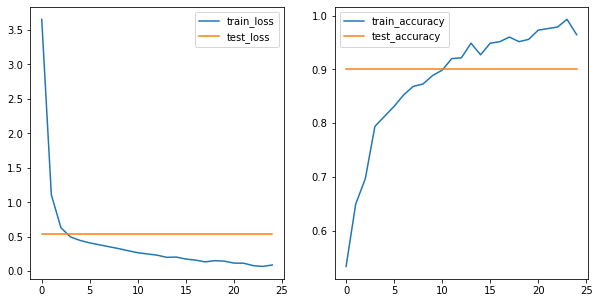

In [500]:
# this isn't fully correct, think we needed to add validation or test data as the validation set in the compile step
# mess around with this tomorrow

train_loss = final_results.history['loss']
train_accuracy = final_results.history['accuracy']
train_recall = final_results.history['recall_5']
train_precision = final_results.history['precision_5']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=final_results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=final_results.epoch, y=train_accuracy, ax=ax2, label='train_accuracy')

sns.lineplot(x=final_results.epoch, y=final_test_loss, ax=ax1, label='test_loss')
sns.lineplot(x=final_results.epoch, y=final_test_acc, ax=ax2, label='test_accuracy');

Confusion matrix: 

In [535]:
# make predictions
final_preds = final_model.predict(test_images)

In [536]:
predicted_classes = [1 if pred > 0.5 else 0 for pred in final_preds]

In [537]:
cm = confusion_matrix(y_true=test_labels_final, y_pred=predicted_classes)

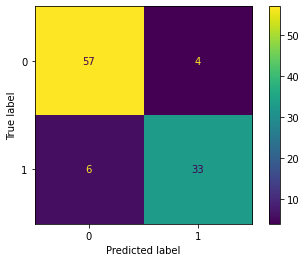

In [539]:
ConfusionMatrixDisplay(cm).plot();

In [533]:
# getting a smaller confusion matrix because we did batches of 100, not sure why it's not using the entire test set
# 57 true negatives, 33 true positives, 6 false negatives and 4 false positives